В этом проекте применим линейную регрессию на практике – попробуем предсказать стоимость машин и понять, от каких факторов зависит ценообразование на автомобили. Помимо этого узнаем, какие переменные важны для прогнозирования и насколько хорошо полученная модель описывает данные.

---

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
sales = pd.read_csv('https://stepik.org/media/attachments/lesson/387691/cars.csv')

In [3]:
sales.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
sales.shape

(205, 26)

In [5]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [6]:
sales.isna().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

In [7]:
# Создадим столбец, куда для удобства запишем сокращенное название автомобиля
sales.insert(3, 'company', '')

In [8]:
sales['company'] = sales.CarName.apply(lambda x: x.split(' ')[0])
sales.head()

,car_ID,symboling,CarName,company,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,alfa-romero,gas,std,two,hatchback,rwd,front,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,audi,gas,std,four,sedan,fwd,front,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,audi,gas,std,four,sedan,4wd,front,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [9]:
# Удалим ненужные столбцы
sales.drop(['CarName', 'car_ID'], axis=1, inplace = True)

In [10]:
sales.company.nunique()

28

In [11]:
# В данных есть названия марок с ошибкой
sales.company.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [12]:
# Исправим названия марок
sales = sales.replace(['maxda', 'Nissan', 'porcshce', 'toyouta', 'vokswagen', 'vw'], 
                      ['mazda', 'nissan', 'porsche', 'toyota',  'volkswagen', 'volkswagen']
                     )

In [13]:
sales.company.nunique()

22

In [14]:
# Чтобы не перегружать модель большим количеством предикторов, оставим только часть из них
categories = (['company', 'fueltype', 'aspiration','carbody', 'drivewheel', 
              'wheelbase', 'carlength','carwidth', 'curbweight', 'enginetype', 
              'cylindernumber', 'enginesize', 'boreratio','horsepower', 'price'])
sales = sales[categories]
sales.head()

,company,fueltype,aspiration,carbody,drivewheel,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,boreratio,horsepower,price
0,alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,four,130,3.47,111,13495.0
1,alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,four,130,3.47,111,16500.0
2,alfa-romero,gas,std,hatchback,rwd,94.5,171.2,65.5,2823,ohcv,six,152,2.68,154,16500.0
3,audi,gas,std,sedan,fwd,99.8,176.6,66.2,2337,ohc,four,109,3.19,102,13950.0
4,audi,gas,std,sedan,4wd,99.4,176.6,66.4,2824,ohc,five,136,3.19,115,17450.0


In [15]:
# Посмотрим на корреляцию переменных
sales.corr()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,price
wheelbase,1.000000,0.874587,0.795144,0.776386,0.569329,0.488750,0.353294,0.577816
carlength,0.874587,1.000000,0.841118,0.877728,0.683360,0.606454,0.552623,0.682920
carwidth,0.795144,0.841118,1.000000,0.867032,0.735433,0.559150,0.640732,0.759325
curbweight,0.776386,0.877728,0.867032,1.000000,0.850594,0.648480,0.750739,0.835305
enginesize,0.569329,0.683360,0.735433,0.850594,1.000000,0.583774,0.809769,0.874145
boreratio,0.488750,0.606454,0.559150,0.648480,0.583774,1.000000,0.573677,0.553173
horsepower,0.353294,0.552623,0.640732,0.750739,0.809769,0.573677,1.000000,0.808139
price,0.577816,0.682920,0.759325,0.835305,0.874145,0.553173,0.808139,1.000000


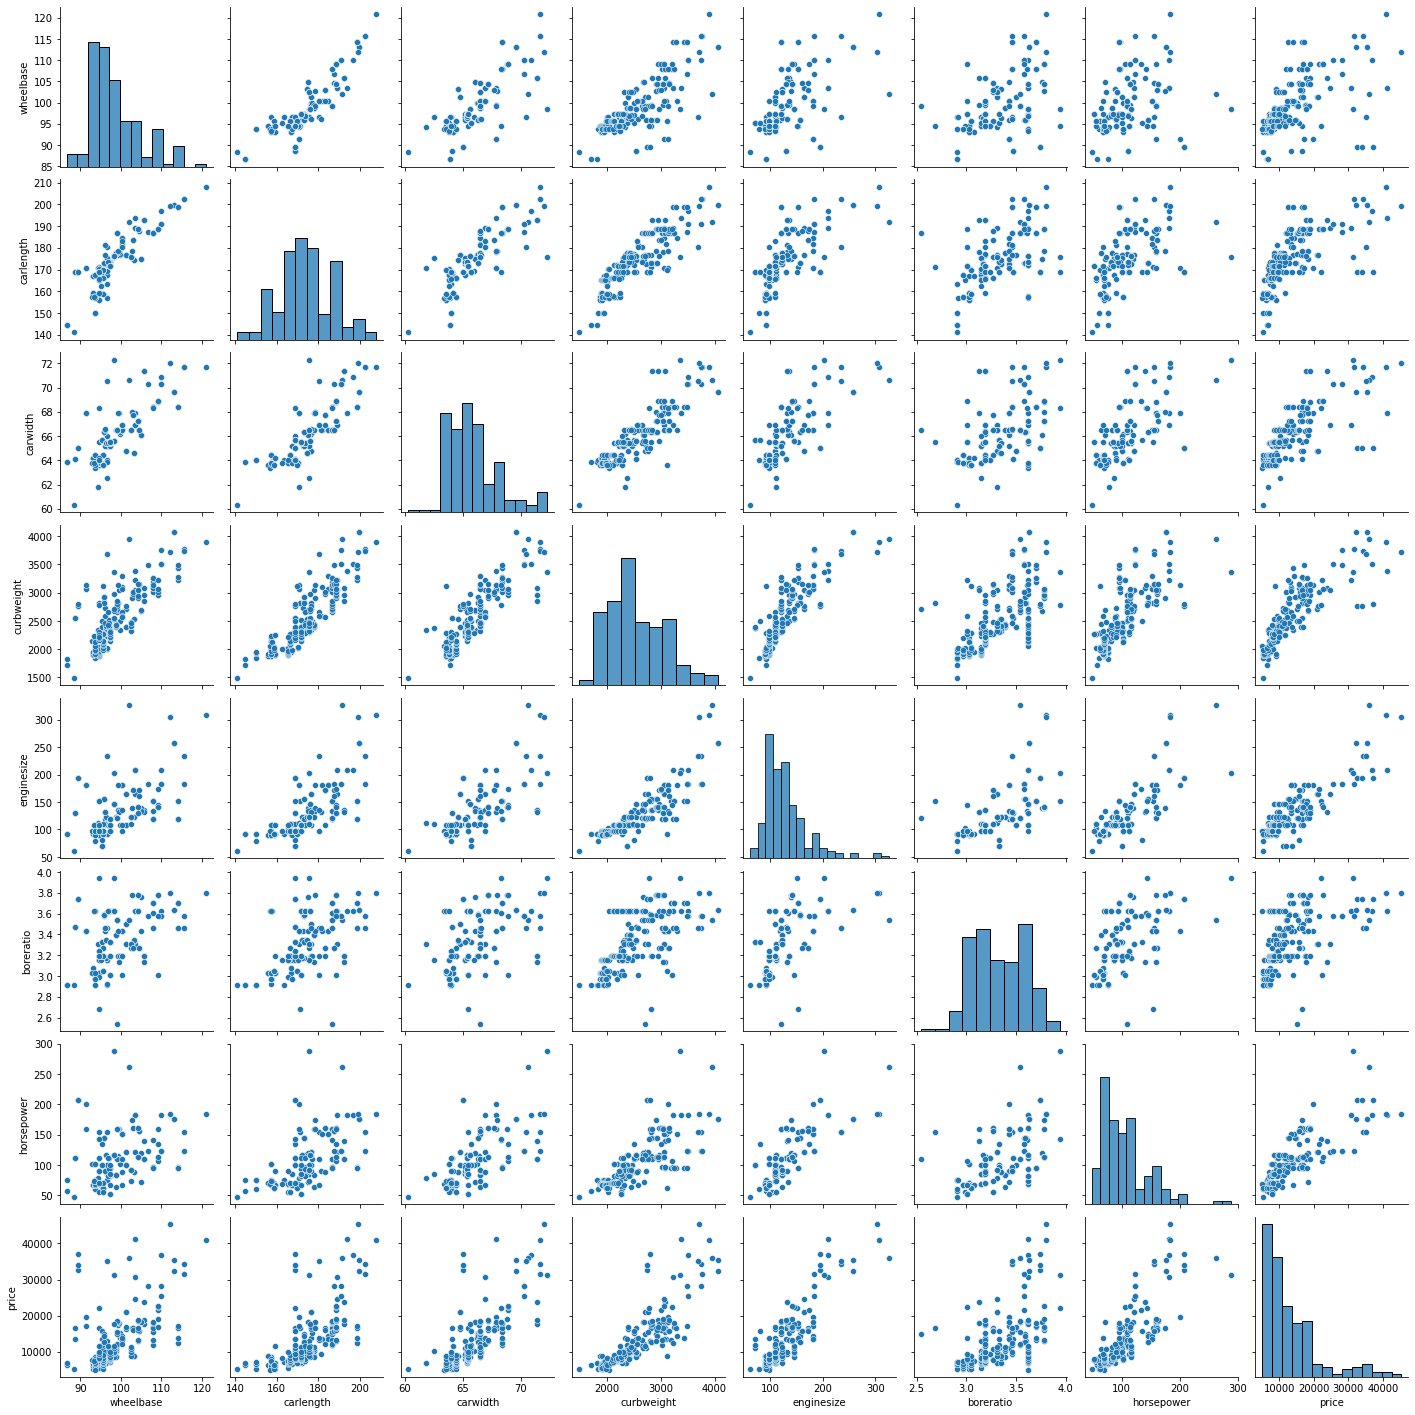

In [16]:
sns.pairplot(sales)

In [17]:
# Проведем one-hot encoding наших категориальных переменных
df_dummy = pd.get_dummies(data=sales, drop_first = True)

In [18]:
df_dummy

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,price,company_audi,company_bmw,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
0,88.6,168.8,64.1,2548,130,3.47,111,13495.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,88.6,168.8,64.1,2548,130,3.47,111,16500.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,94.5,171.2,65.5,2823,152,2.68,154,16500.0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,99.8,176.6,66.2,2337,109,3.19,102,13950.0,1,0,...,1,0,0,0,0,1,0,0,0,0
4,99.4,176.6,66.4,2824,136,3.19,115,17450.0,1,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,109.1,188.8,68.9,2952,141,3.78,114,16845.0,0,0,...,1,0,0,0,0,1,0,0,0,0
201,109.1,188.8,68.8,3049,141,3.78,160,19045.0,0,0,...,1,0,0,0,0,1,0,0,0,0
202,109.1,188.8,68.9,3012,173,3.58,134,21485.0,0,0,...,0,0,1,0,0,0,1,0,0,0
203,109.1,188.8,68.9,3217,145,3.01,106,22470.0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [19]:
# Сначала построим небольшую модель всего с одним предиктором цены (price) – horsepower
model = smf.ols(formula = 'price ~ horsepower', data = df_dummy).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     382.2
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           1.48e-48
Time:                        14:13:44   Log-Likelihood:                -2024.0
No. Observations:                 205   AIC:                             4052.
Df Residuals:                     203   BIC:                             4059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3721.7615    929.849     -4.003      0.000   -5555.163   -1888.360
horsepower   163.2631      8.351     19.549      0.000     146.796     179.730
==============================================================================
Omnibus:                       47.741   Durbin-Watson:                   0.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.702
Skew:                           1.141   Prob(JB):                     1.22e-20
Kurtosis:                       5.352   Cond. No.                         314.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Теперь построим модель со всеми предикторами
predictors_2 = '+'.join(df_dummy.drop('price', axis=1).columns)
model_2 = smf.ols(formula = 'price ~ ' + predictors_2, data = df_dummy).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     81.09
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           4.86e-89
Time:                        14:13:44   Log-Likelihood:                -1804.2
No. Observations:                 205   AIC:                             3702.
Df Residuals:                     158   BIC:                             3858.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -3.472e+04   1.17e+04     -2.959      0.004   -5.79e+04   -1.15e+04
wheelbase               147.1396     76.234      1.930      0.055      -3.429     297.708
carlength              -113.2012     48.949     -2.313      0.022    -209.881     -16.522
carwidth                809.1860    214.508      3.772      0.000     385.514    1232.858
curbweight                4.1822      1.582      2.643      0.009       1.057       7.307
enginesize               61.4212     23.643      2.598      0.010      14.724     108.119
boreratio             -4319.4728   1759.825     -2.454      0.015   -7795.288    -843.657
horsepower               34.7010     18.000      1.928      0.056      -0.850      70.252
company_audi            437.1040   2125.971      0.206      0.837   -3761.885    4636.093
company_bmw            7993.4998   2105.132      3.797      0.000    3835.671    1.22e+04
company_buick          3431.0969   2472.252      1.388      0.167   -1451.829    8314.023
company_chevrolet     -2107.0167   2054.269     -1.026      0.307   -6164.387    1950.353
company_dodge         -3034.5530   1686.337     -1.799      0.074   -6365.224     296.118
company_honda         -2328.7396   1622.141     -1.436      0.153   -5532.617     875.138
company_isuzu          -926.1643   1819.489     -0.509      0.611   -4519.823    2667.495
company_jaguar         2695.2664   2546.268      1.059      0.291   -2333.847    7724.379
company_mazda         -1291.5657   1652.561     -0.782      0.436   -4555.527    1972.395
company_mercury       -2762.0259   2786.701     -0.991      0.323   -8266.016    2741.965
company_mitsubishi    -3699.6473   1650.046     -2.242      0.026   -6958.640    -440.654
company_nissan        -1488.1217   1563.564     -0.952      0.343   -4576.305    1600.061
company_peugeot       -2671.4595   1795.328     -1.488      0.139   -6217.398     874.479
company_plymouth      -3052.1258   1670.829     -1.827      0.070   -6352.166     247.915
company_porsche        4915.9715   2797.761      1.757      0.081    -609.864    1.04e+04
company_renault       -2865.2197   2073.046     -1.382      0.169   -6959.676    1229.237
company_saab            719.8222   1767.620      0.407      0.684   -2771.390    4211.035
company_subaru        -1.164e+04   3416.221     -3.407      0.001   -1.84e+04   -4892.375
company_toyota        -2608.7871   1539.320     -1.695      0.092   -5649.086     431.512
company_volkswagen    -2261.9355   1606.886     -1.408      0.161   -5435.683     911.812
company_volvo            68.2605   1943.170      0.035      0.972   -3769.679    3906.200
fueltype_gas           -243.7792    908.310     -0.268      0.789   -2037.774    1550.216
aspiration_turbo        596.6566    676.548      0.882      0.379    -739.588    1932.902
carbody_hardtop       -

In [21]:
# Теперь построим модель со всеми предикторами, кроме марки машины
sales_ = sales.drop('company', axis=1)
predictors_3 = '+'.join(sales_.drop('price', axis=1).columns)
model_3 = smf.ols(formula = 'price ~ ' + predictors_3, data = sales_).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     72.32
Date:                Thu, 10 Nov 2022   Prob (F-statistic):           9.86e-81
Time:                        14:13:44   Log-Likelihood:                -1881.6
No. Observations:                 205   AIC:                             3817.
Df Residuals:                     178   BIC:                             3907.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -1.7e+04    1.3e+04     -1.309      0.192   -4.26e+04    8625.219
fueltype[T.gas]          -2423.0935    975.579     -2.484      0.014   -4348.283    -497.904
aspiration[T.turbo]      -1139.2334    787.230     -1.447      0.150   -2692.738     414.271
carbody[T.hardtop]       -3728.0949   1519.366     -2.454      0.015   -6726.383    -729.807
carbody[T.hatchback]     -4639.1279   1294.594     -3.583      0.000   -7193.855   -2084.401
carbody[T.sedan]         -3337.7854   1356.075     -2.461      0.015   -6013.838    -661.732
carbody[T.wagon]         -4315.4661   1465.089     -2.946      0.004   -7206.646   -1424.287
drivewheel[T.fwd]          297.2402   1121.766      0.265      0.791   -1916.431    2510.912
drivewheel[T.rwd]         1939.1594   1226.536      1.581      0.116    -481.263    4359.582
enginetype[T.dohcv]      -1.713e+04   4540.120     -3.773      0.000   -2.61e+04   -8171.142
enginetype[T.l]           2176.0521   1332.818      1.633      0.104    -454.106    4806.211
enginetype[T.ohc]         4006.5687    897.437      4.464      0.000    2235.584    5777.553
enginetype[T.ohcf]        5421.2822   1388.078      3.906      0.000    2682.076    8160.488
enginetype[T.ohcv]       -5001.2242   1345.435     -3.717      0.000   -7656.280   -2346.169
enginetype[T.rotor]      -5196.6413   2084.532     -2.493      0.014   -9310.217   -1083.066
cylindernumber[T.five]   -1.389e+04   2891.599     -4.802      0.000   -1.96e+04   -8180.353
cylindernumber[T.four]   -1.618e+04   3243.610     -4.989      0.000   -2.26e+04   -9780.800
cylindernumber[T.six]    -1.175e+04   2287.516     -5.135      0.000   -1.63e+04   -7231.547
cylindernumber[T.three]  -9264.0553   4750.899     -1.950      0.053   -1.86e+04     111.279
cylindernumber[T.twelve] -1.214e+04   3386.507     -3.585      0.000   -1.88e+04   -5458.378
cylindernumber[T.two]    -5196.6413   2084.532     -2.493      0.014   -9310.217   -1083.066
wheelbase                   71.1868     87.028      0.818      0.414    -100.552     242.925
carlength                  -51.3497     50.341     -1.020      0.309    -150.692      47.993
carwidth                   541.8700    253.327      2.139      0.034      41.958    1041.782
curbweight                   2.9577      1.796      1.647      0.101      -0.585       6.501
enginesize                  36.0515     22.376      1.611      0.109      -8.105      80.208
boreratio                -2230.4519   1731.681     -1.288      0.199   -5647.719    1186.815
horsepower                  86.8164     16.717      5.193      0.000      53.827     119.806
==============================================================================
Omnibus:                       18.493   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.000   Ja

In [22]:
#  хотя марки машин и объясняют какую-то часть общей дисперсии в данных, эта часть не самая большая - около 4%.
# На фоне того, как эта переменная усложняет модель дополнительными статнезначимыми коэффициентами, 
# мы можем принять решение выкинуть её из модели либо дополнительно переделать

In [23]:
sales.head()

,company,fueltype,aspiration,carbody,drivewheel,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,boreratio,horsepower,price
0,alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,four,130,3.47,111,13495.0
1,alfa-romero,gas,std,convertible,rwd,88.6,168.8,64.1,2548,dohc,four,130,3.47,111,16500.0
2,alfa-romero,gas,std,hatchback,rwd,94.5,171.2,65.5,2823,ohcv,six,152,2.68,154,16500.0
3,audi,gas,std,sedan,fwd,99.8,176.6,66.2,2337,ohc,four,109,3.19,102,13950.0
4,audi,gas,std,sedan,4wd,99.4,176.6,66.4,2824,ohc,five,136,3.19,115,17450.0


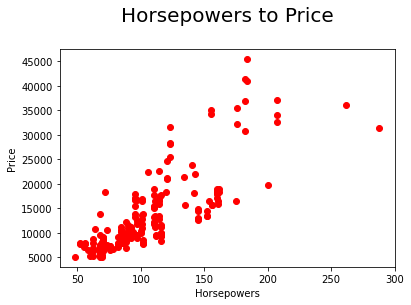

In [33]:
plt.scatter(sales.horsepower, sales.price, color='red', label='dependence')

plt.title('Horsepowers to Price\n', fontdict={'fontname':'DejaVu Sans', 'fontsize': 20})
plt.xlabel('Horsepowers')
plt.ylabel('Price')

plt.show()